In [456]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import scipy.io
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from ADM import ADM
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import normalize

from data_loader import load_pickle, unpack_data
from mutual_information import (
    compute_mutual_information,
    create_spectrogram,
    to_spikes_and_back,
    first_order_low_pass,
    compute_cv_regression_score
)
sns.set()

SUBJECT_IDX = 3

In [457]:
dataset = load_pickle(SUBJECT_IDX)
ppg, acc, hr, activity, _= unpack_data(dataset)

In [458]:
duration = 100
fs = 64
fmin = 0.5
fmax = 2.5

#hr = np.linspace(fmin, fmax, duration * fs)
#clean_signal = signal.chirp(np.arange(0, duration, 1 / fs), f0=fmin, f1=fmax, t1=duration, method='linear')
#noise = signal.chirp(np.arange(0, duration, 1 / fs), f0=fmin, f1=fmax, t1=duration, method='linear', phi=180) * 0.5
#ppg = clean_signal + noise

In [564]:
def amplitude_normalize(signal, slice_width=512):
    slices = np.arange(0, len(ppg), slice_width)
    signal_copy = signal.copy()
    for slice_start in slices:
        considered_slice = signal[slice_start:slice_start+slice_width]
        signal_copy[slice_start:slice_start+slice_width] = considered_slice / np.std(considered_slice)
    return signal_copy

### Create spectrogram of PPG signal

<ipython-input-584-39d07c070dbe>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')


Text(0.5, 0, 'Time [s]')

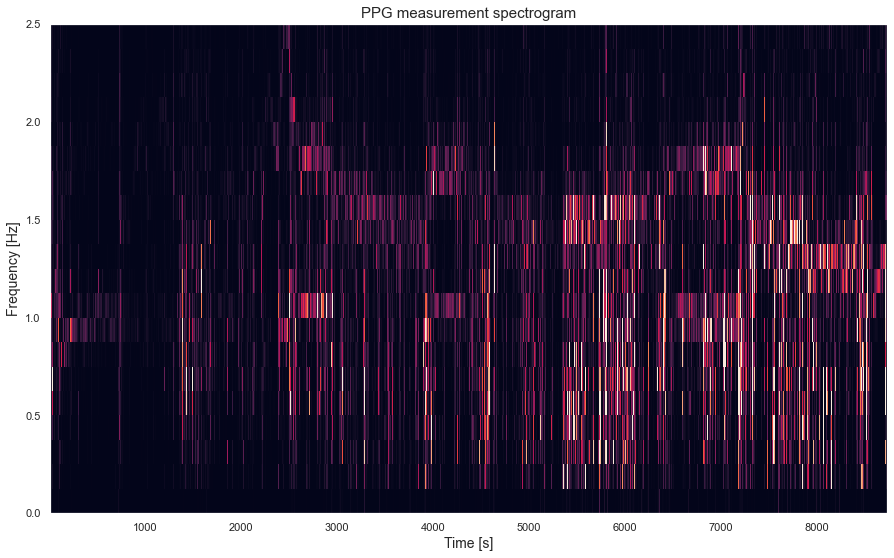

In [584]:
fs_ppg = 64
nperseg_ppg = 8 * 64
noverlap = 6 * 64
fmin = 0 # Hz
fmax = 2.5 # Hz

ppg_amp_normalized = amplitude_normalize(ppg, 64 * 4)

hr_timestamps = np.arange(4, len(hr) * 2 + 4, 2)
#hr_timestamps = np.arange(0, duration, 1 / fs)  # only valid for artificial signal
hr_interpolation = interpolate.interp1d(hr_timestamps, hr)

### create spectrogram
f_ppg, t_ppg, Sxx_ppg = create_spectrogram(ppg, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)
_, _, Sxx_ppg_amp_normalized = create_spectrogram(ppg_amp_normalized, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)

# interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_ppg)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg, shading='flat')
plt.title('PPG measurement spectrogram', fontsize=15)
plt.ylabel('Frequency [Hz]', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)


#plt.plot(t_ppg, hr_at_ppg_timestamps)

### Run PPG through ADM

In [585]:
ADM_factor = 0.1
ADM_step_size = ADM_factor * np.mean(abs(ppg))
up_spikes, down_spikes = ADM(
    ppg,
    up_threshold=ADM_step_size,
    down_threshold=ADM_step_size,
    sampling_rate=fs_ppg,
    refractory_period=0
)

In [586]:
mean_spike_rate = (len(up_spikes) + len(down_spikes)) / len(ppg) * 64
print('mean spike rate:', mean_spike_rate)

mean spike rate: 37.05708728978378


### Reconstruct original signal from ADM-generated spike train using gaussian kernel

In [587]:
def exp_decaying_filter(tau):
    return np.exp(-np.arange(0, tau * 5, 1 / 64) / tau) / tau

In [588]:
def reconstruct_from_spikes(spikes, length, spike_value, use_exponential=False, tau=0.1):
    reconstructed_signal = np.zeros(length)
    spikes_sampling_rate_indices = (spikes * 64).astype(int)
    reconstructed_signal[spikes_sampling_rate_indices] = spike_value
    
    if use_exponential:
        reconstructed_signal = signal.convolve(reconstructed_signal, exp_decaying_filter(tau), mode='full')[:length]
    else:
        reconstructed_signal = gaussian_filter1d(reconstructed_signal, 10)
    return reconstructed_signal

In [589]:
high_tau = 0.35
low_tau = 0.3

reconstructed_signal = (
    reconstruct_from_spikes(up_spikes, len(ppg), 1, tau=low_tau) +
    reconstruct_from_spikes(down_spikes, len(ppg), -1, tau=low_tau) #+
    #reconstruct_from_spikes(up_spikes, len(ppg), -1, tau=high_tau) +
    #reconstruct_from_spikes(down_spikes, len(ppg), 1, tau=high_tau)
)
#reconstructed_signal = gaussian_filter1d(ppg, 1)

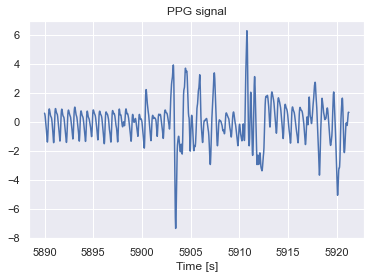

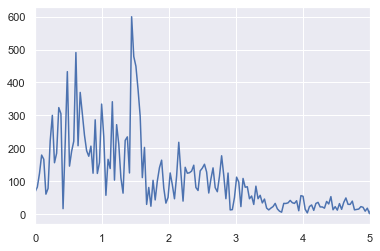

In [590]:
plot_segment_start_seconds = 5890
plot_segment_start = plot_segment_start_seconds * 64
plot_segment_length = 2000
plot_fft = True

time_segment = np.arange(plot_segment_start, plot_segment_start+plot_segment_length, 1) / 64
ppg_segment = ppg[plot_segment_start:plot_segment_start+plot_segment_length]
ppg_segment = ppg_segment / np.mean(abs(ppg_segment))
plt.plot(time_segment, ppg_segment)
plt.xlabel('Time [s]')
plt.title('PPG signal')
plt.show()

if plot_fft:
    ppg_spectrum = abs(fft(ppg_segment)[:len(ppg_segment)//2])
    freqs = fftfreq(len(ppg_segment), 1 / 64)[:len(ppg_segment)//2]
    plt.plot(freqs, ppg_spectrum)
    plt.xlim(0, 5)

In [591]:
np.mean([hr_interpolation(t) for t in np.linspace(plot_segment_start_seconds, plot_segment_start_seconds + plot_segment_length, 10)])

1.57065960696862

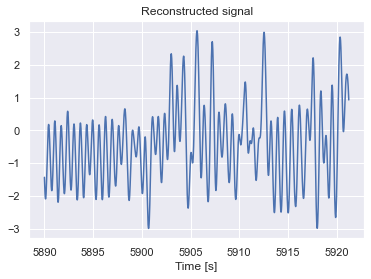

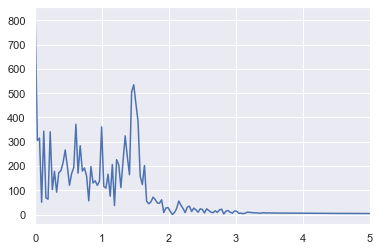

In [592]:
rec_segment = reconstructed_signal[plot_segment_start:plot_segment_start+plot_segment_length]
rec_segment = rec_segment / np.mean(abs(rec_segment))
plt.plot(time_segment, rec_segment)
plt.xlabel('Time [s]')
plt.title('Reconstructed signal')
plt.show()

if plot_fft:
    rec_spectrum = abs(fft(rec_segment)[:len(rec_segment)//2])
    freqs = fftfreq(len(rec_segment), 1 / 64)[:len(rec_segment)//2]
    plt.plot(freqs, rec_spectrum)
    plt.xlim(0, 5)

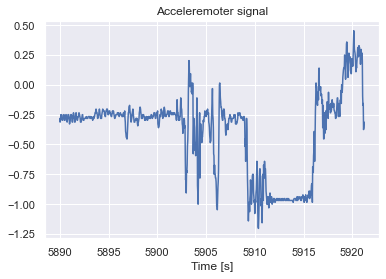

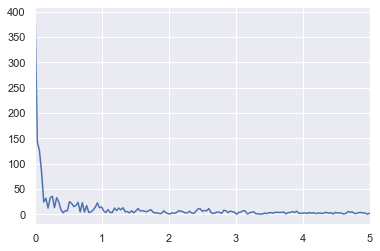

In [593]:
acc_segment = acc[plot_segment_start // 2:(plot_segment_start+plot_segment_length) // 2]
plt.plot(time_segment[::2], acc_segment)
plt.xlabel('Time [s]')
plt.title('Acceleremoter signal')
plt.show()

if plot_fft:
    acc_spectrum = abs(fft(acc_segment)[:len(acc_segment)//2])
    freqs = fftfreq(len(acc_segment), 1 / 32)[:len(acc_segment)//2]
    plt.plot(freqs, acc_spectrum)
    plt.xlim(0, 5)

### Create spectrogram of reconstructed signal

<ipython-input-594-60e36cf43055>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')


Text(0.5, 0, 'Time [s]')

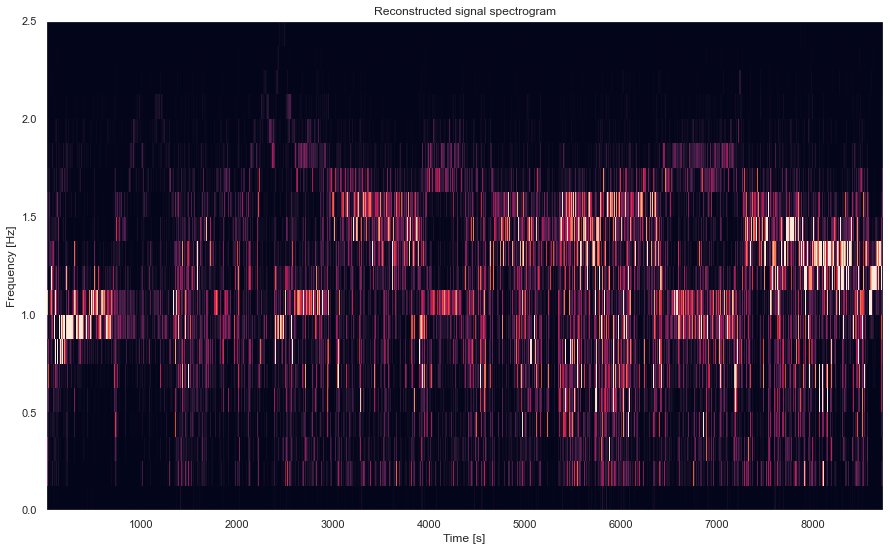

In [594]:
### create spectrogram
f_rec, t_rec, Sxx_rec = create_spectrogram(reconstructed_signal, fs_ppg, nperseg_ppg, noverlap, fmin, fmax, clip_percentile=99)

### interpolate relevant heart rate measurements
hr_at_ppg_timestamps = hr_interpolation(t_rec)

### plot ppg spectrogram
plt.figure(figsize=(15, 9))
plt.pcolormesh(t_rec, f_rec, Sxx_rec, shading='flat')
plt.title('Reconstructed signal spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

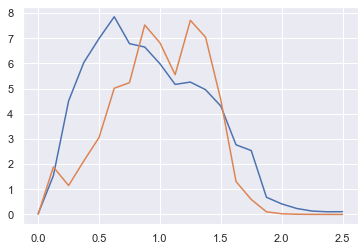

In [595]:
plt.plot(f_ppg, np.var(Sxx_ppg, axis=1))
plt.plot(f_rec, np.var(Sxx_rec, axis=1))

In [596]:
ppg_scaled = (ppg - np.mean(ppg)) / np.std(ppg)
rec_scaled = (reconstructed_signal - np.mean(reconstructed_signal)) / np.std(reconstructed_signal)

In [597]:
np.var(ppg_scaled)

1.0000000000000004

In [598]:
np.var(rec_scaled)

1.0

Text(0, 0.5, 'Variance in time window')

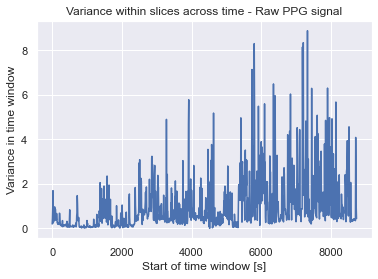

In [599]:
slice_width = 512
slices = np.arange(0, len(ppg), slice_width)
ppg_var_across_time = [np.var(ppg_scaled[i:i+slice_width]) for i in slices]
plt.plot(slices / 64, ppg_var_across_time)
plt.title('Variance within slices across time - Raw PPG signal')
plt.xlabel('Start of time window [s]')
plt.ylabel('Variance in time window')

Text(0, 0.5, 'Variance in time window')

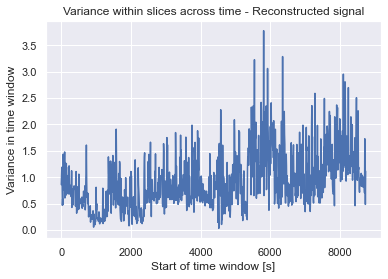

In [600]:
slice_width = 512
slices = np.arange(0, len(reconstructed_signal), slice_width)
rec_var_across_time = [np.var(rec_scaled[i:i+slice_width]) for i in slices]
plt.plot(slices / 64, rec_var_across_time)
plt.title('Variance within slices across time - Reconstructed signal')
plt.xlabel('Start of time window [s]')
plt.ylabel('Variance in time window')

In [601]:
np.var(ppg_var_across_time) / np.var(rec_var_across_time)

5.121241610137749

### Mutual information

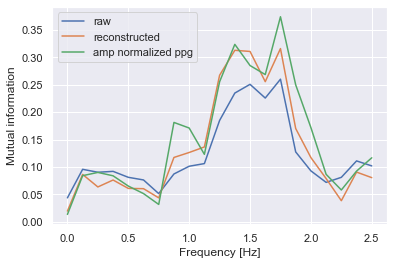

In [602]:
n_neighbors = 10
num_hr_bins = 15
num_power_bins = 6

Sxx_rec_normalized = normalize(Sxx_rec, axis=0)
#mutual_info_rec = compute_mutual_information(Sxx_rec, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_info_rec_sklearn = mutual_info_regression(np.transpose(Sxx_rec), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
#mutual_info_ppg = compute_mutual_information(Sxx_ppg, hr_at_ppg_timestamps, num_hr_bins, num_power_bins)
mutual_info_ppg_sklearn = mutual_info_regression(np.transpose(Sxx_ppg), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
mutual_info_ppg_normalized_sklearn = mutual_info_regression(np.transpose(Sxx_ppg_amp_normalized), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
mutual_info_rec_normalized_sklearn = mutual_info_regression(np.transpose(Sxx_rec_normalized), hr_at_ppg_timestamps, n_neighbors=n_neighbors)
#plt.plot(f_ppg, mutual_info_ppg, label='ppg')
#plt.plot(f_rec, mutual_info_rec, label='rec')
plt.plot(f_ppg, mutual_info_ppg_sklearn, label='raw')
plt.plot(f_rec, mutual_info_rec_sklearn, label='reconstructed')
plt.plot(f_rec, mutual_info_ppg_normalized_sklearn, label='amp normalized ppg')

plt.ylabel('Mutual information')
plt.xlabel('Frequency [Hz]')
plt.legend()

In [603]:
compute_cv_regression_score(np.transpose(Sxx_ppg_amp_normalized), hr_at_ppg_timestamps)

0.52075899991628